Exploratory Data Analysis (EDA)

In [ ]:
# --- imports
from pathlib import Path
import random, numpy as np, pandas as pd
from PIL import Image, UnidentifiedImageError
from tqdm import tqdm
import matplotlib.pyplot as plt

# --- config
PROJECT_ROOT  = Path("..")                        
PROC_DIR      = PROJECT_ROOT / "data/processed/train"
IMG_SIZE      = (160, 160)
SAMPLE_CLASSES = 5
SAMPLE_PER     = 5
SEED           = 42
random.seed(SEED)

print("Images root  ➜", PROC_DIR.resolve())


Images root  ➜ /Users/sangsun/face-id-project/data/processed/train


In [2]:
# Scan dataset (class counts, brightness, contrast)
class_counts, brightness_arr, contrast_arr = {}, [], []

print("[1/4] Scanning images …")
for fp in tqdm(list(PROC_DIR.rglob("*.png"))):
    label = fp.parent.name
    class_counts[label] = class_counts.get(label, 0) + 1

    try:
        g_arr = np.asarray(Image.open(fp).convert("L"), dtype=np.float32) / 255.0
        brightness_arr.append(g_arr.mean())
        contrast_arr.append(g_arr.std())
    except UnidentifiedImageError:
        continue


[1/4] Scanning images …


100%|██████████| 7836/7836 [00:04<00:00, 1892.58it/s]


,class,image_count
0,George_W_Bush,372
1,Colin_Powell,166
2,Tony_Blair,102
3,Donald_Rumsfeld,85
4,Gerhard_Schroeder,77
5,Ariel_Sharon,55
6,Hugo_Chavez,51
7,Junichiro_Koizumi,42
8,Jean_Chretien,39
9,John_Ashcroft,39


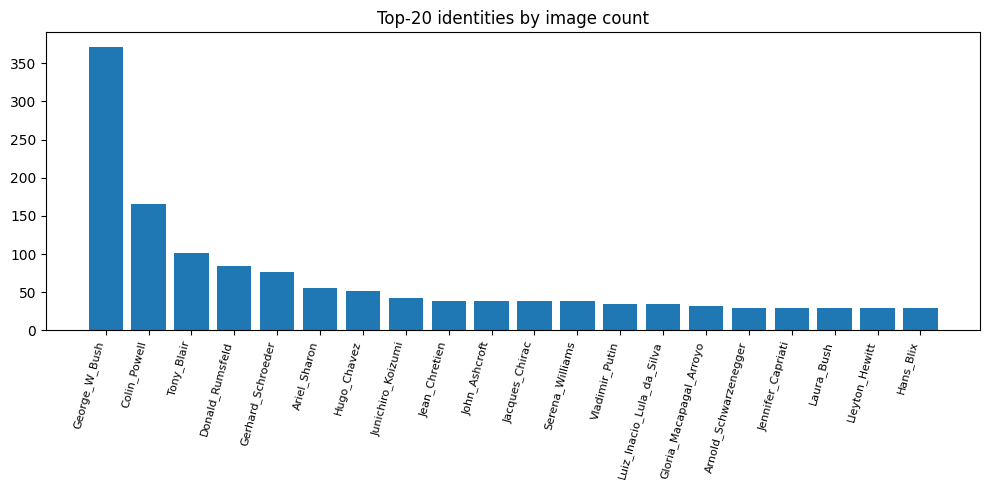

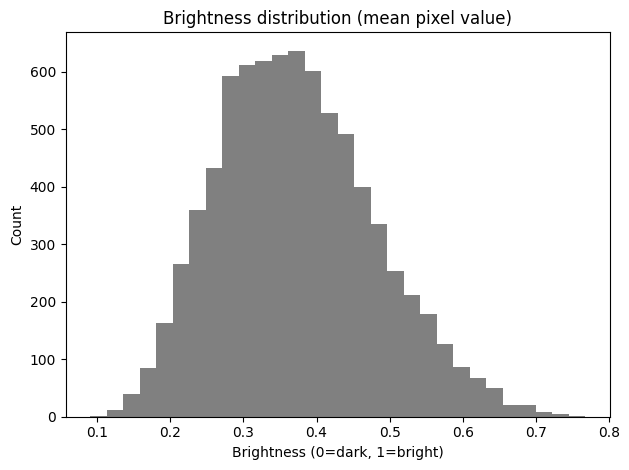

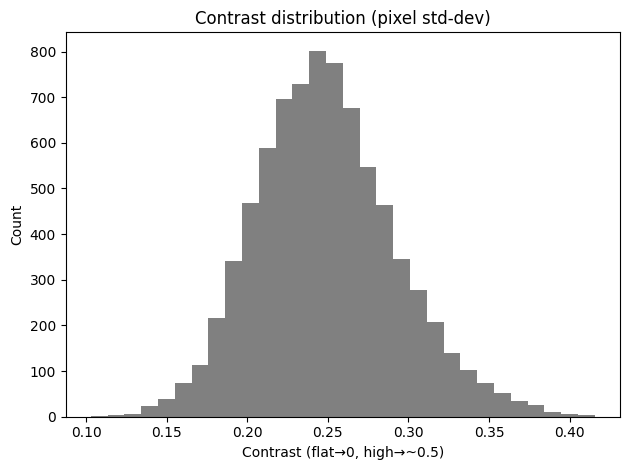

In [3]:
#Class‑distribution table + plots
counts_df = (pd.DataFrame(class_counts.items(), columns=["class","image_count"])
             .sort_values("image_count", ascending=False)
             .reset_index(drop=True))

display(counts_df.head(30))   # top‑30 table

# bar chart for top‑20
top_k = counts_df.head(20)
plt.figure(figsize=(10,5))
plt.bar(top_k["class"], top_k["image_count"])
plt.xticks(rotation=75, ha="right", fontsize=8)
plt.title("Top‑20 identities by image count")
plt.tight_layout(); plt.show()

# brightness histogram
plt.figure()
plt.hist(brightness_arr, bins=30, color='gray')
plt.title("Brightness distribution (mean pixel value)")
plt.xlabel("Brightness (0=dark, 1=bright)"); plt.ylabel("Count")
plt.tight_layout(); plt.show()

# contrast histogram
plt.figure()
plt.hist(contrast_arr, bins=30, color='gray')
plt.title("Contrast distribution (pixel std‑dev)")
plt.xlabel("Contrast (flat→0, high→~0.5)"); plt.ylabel("Count")
plt.tight_layout(); plt.show()


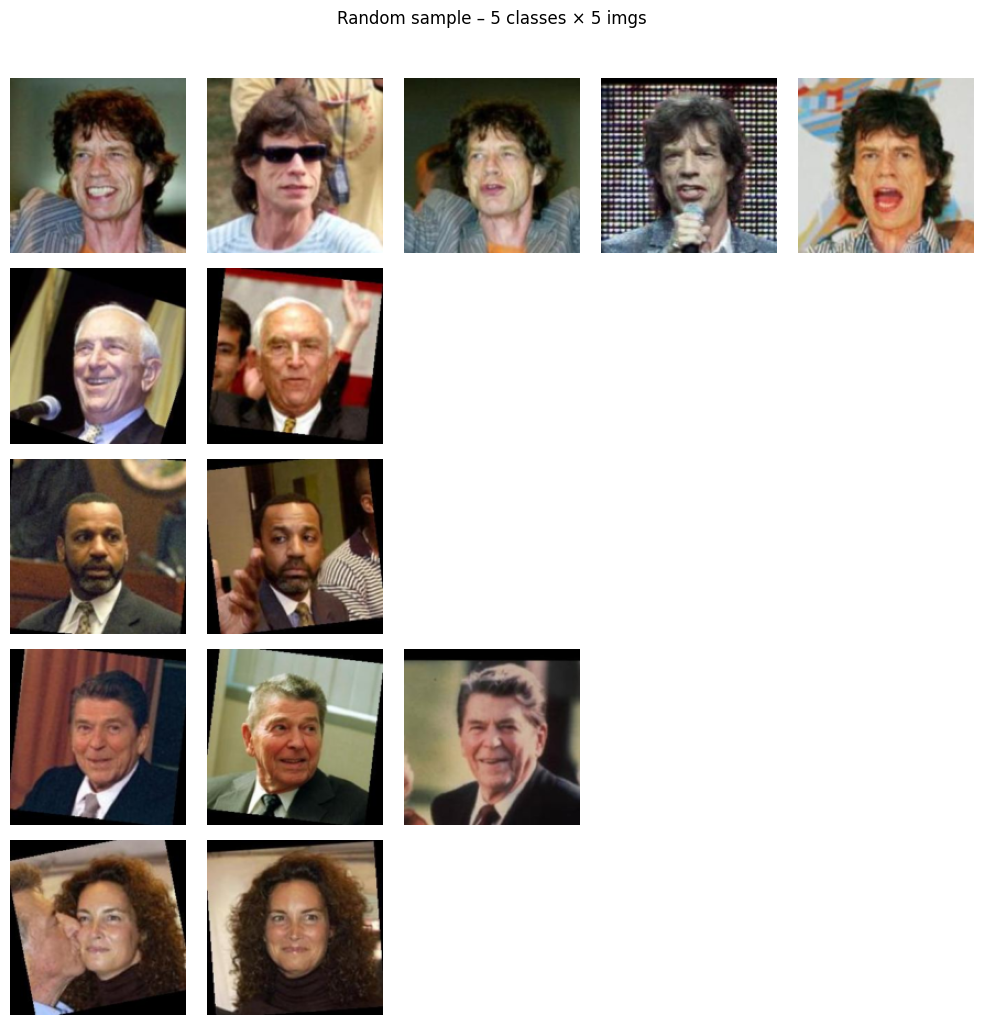

In [4]:
# Random sample grid
sample_classes = min(SAMPLE_CLASSES, len(class_counts))
chosen_labels  = random.sample(list(class_counts), sample_classes)

fig, axes = plt.subplots(sample_classes, SAMPLE_PER,
                         figsize=(SAMPLE_PER*2, sample_classes*2))

for row, lab in enumerate(chosen_labels):
    imgs = list((PROC_DIR / lab).glob("*.png"))
    random.shuffle(imgs); imgs = imgs[:SAMPLE_PER]
    for col in range(SAMPLE_PER):
        ax = axes[row, col]
        if col < len(imgs):
            ax.imshow(Image.open(imgs[col]))
        ax.axis("off")
        if col == 0:
            ax.set_ylabel(lab[:14] + ("…" if len(lab) > 14 else ""),
                          rotation=0, labelpad=30, va="center")

plt.suptitle(f"Random sample – {sample_classes} classes × {SAMPLE_PER} imgs",
             y=1.02)
plt.tight_layout(); plt.show()


“Dataset is highly imbalanced (top 10 classes = 22 % of data).
Brightness centred at 0.35 ± 0.08 suggests mid‑exposed images; we’ll augment ±20 %.
Most identities have ≤ 5 images → heavy augmentation & transfer learning needed.”